# Pre-Processing

## Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist, pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
import re
import string

## Load & Check Data 

In [2]:
bc_data = './data/bitcoin.csv'
bc = pd.read_csv(bc_data)

In [3]:
eth_data = './data/ethereum.csv'
eth = pd.read_csv(eth_data)

In [4]:
bc.shape 

(7458, 9)

In [5]:
eth.shape

(7228, 9)

In [6]:
bc.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Passive Bit/Altcoin apps?,"Hi all, kinda new to crypto and i saw a thread...",Bitcoin,1619299928,Comfortable-Hall-501,7,1,True,2021-04-24
1,Why I think Dorian Satoshi Nakamoto is creator...,I know that Dorian denied he is creator of Bit...,Bitcoin,1619300188,bruh_360,4,1,True,2021-04-24
2,Why wont bitcoin get regulated,Im new to cryptocurrency or even the blockchai...,Bitcoin,1619300698,No-Librarian9752,9,1,True,2021-04-24
3,The beginning of a journey,"Hey everyone, this last week has been an emoti...",Bitcoin,1619301239,Mammoth_Lettuce_6706,11,1,True,2021-04-24
4,real inflation rates,"In 2010, there was a pretty famous study about...",Bitcoin,1619302086,Easteuroblondie,93,1,True,2021-04-24


In [7]:
eth.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,How would you invest some couple of thousand U...,[removed],ethereum,1619305684,edikrq,0,1,True,2021-04-24
1,To stake or not to stake?,[removed],ethereum,1619307135,HaoleGuy808,27,1,True,2021-04-24
2,Are there symbiotic ETH chains?,[removed],ethereum,1619307984,aklosk,0,1,True,2021-04-24
3,Is ETH always this volatile? I bought for the ...,So it reached an ATH and I bought it and now i...,ethereum,1619308354,thegreathand,15,1,True,2021-04-24
4,Ethereum Realized Market Cap,Basically I've been looking for any charts of ...,ethereum,1619308508,samzuir,0,1,True,2021-04-24


In [8]:
df = pd.concat([bc, eth], ignore_index=True)

To make cleaning easier, the two subreddit dataframes will be combined.

In [9]:
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Passive Bit/Altcoin apps?,"Hi all, kinda new to crypto and i saw a thread...",Bitcoin,1619299928,Comfortable-Hall-501,7,1,True,2021-04-24
1,Why I think Dorian Satoshi Nakamoto is creator...,I know that Dorian denied he is creator of Bit...,Bitcoin,1619300188,bruh_360,4,1,True,2021-04-24
2,Why wont bitcoin get regulated,Im new to cryptocurrency or even the blockchai...,Bitcoin,1619300698,No-Librarian9752,9,1,True,2021-04-24
3,The beginning of a journey,"Hey everyone, this last week has been an emoti...",Bitcoin,1619301239,Mammoth_Lettuce_6706,11,1,True,2021-04-24
4,real inflation rates,"In 2010, there was a pretty famous study about...",Bitcoin,1619302086,Easteuroblondie,93,1,True,2021-04-24


## Cleaning 

It looks like the selftext column has a lot of removed posts, and to a lesser extent deleted posts, so let's remove every occurence of [removed] and [deleted] with empty strings. This way, we can still keep data from the title column. In a later step, let's create a new column that combines the title and selftext data.

In [12]:
def rem_del(df, text_col):
    df[text_col] = df[text_col].map(lambda x: '' if x == '[removed]' else x)
    df[text_col] = df[text_col].map(lambda x: '' if x == '[deleted]' else x)
    return df 
df = rem_del(df, 'selftext')

Let's drop duplicates and null values so we don't skew word count analysis later on. This was already done in the automated scraping function, so this is more of a double check.

In [13]:
df = df.drop_duplicates()

In [14]:
df.dropna(inplace=True)

In [15]:
df.isnull().sum()

title           0
selftext        0
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

In [16]:
df.shape

(14048, 9)

As previously mentioned, let's create a new column that combines the text from the title and selftext columns.  Not only will this give the model more data to assess, the Ethereum subreddit has over 5000 removed/deleted posts, so this will prevent that data from being reduced significantly.

In [17]:
df['title_and_selftext'] = df['title'] + ' ' + df['selftext']

# Aderinsola gave me the idea to create a column to combine title and selftext. Thanks, Aderinsola!

For the next round of cleaning, we'll need to lowercase all the text, pull out punctuation, numbers, and remaining html code like '/n'. Running the text through a RegEx cleaning function will strip out that unwanted text.

In [18]:
def clean_text(text_col):
    df[text_col] = df[text_col].str.lower()
    df[text_col] = df[text_col].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    df[text_col] = df[text_col].apply(lambda elem: re.sub(r"([‘’“”…])|\n|\[.*?\]|\w*\d\w*", "", elem))
    df[text_col] = df[text_col].apply(lambda elem: re.sub(r"\d+", "", elem))                                                                                                          
    return df 

In [19]:
text_cols = ['title', 'selftext', 'title_and_selftext']

In [20]:
for col in text_cols:
    clean_text(col)

Since we'll eventually try to have our models determine if a post came from the Bitcoin or Ethereum subreddits, let's create a new column that gives numeric values to each thread: 0 to Ethereum and 1 to Bitcoin.

In [21]:
df['is_bitcoin'] = df['subreddit'].map(lambda x: 1 if x == 'Bitcoin' else 0)

In [22]:
df['is_bitcoin'].value_counts()

1    7091
0    6957
Name: is_bitcoin, dtype: int64

## Stop Words 

In this analysis, stopwords won't play much of a role, so we can remove them to get more meaningful results out of EDA and modeling.

In [23]:
stop = stopwords.words('english')

df['selftext'] = df['selftext'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['title_and_selftext'] = df['title_and_selftext'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

# https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,title_and_selftext,is_bitcoin
0,passive bitaltcoin apps,hi kinda new crypto saw thread day good recomm...,Bitcoin,1619299928,Comfortable-Hall-501,7,1,True,2021-04-24,passive bitaltcoin apps hi kinda new crypto sa...,1
1,why i think dorian satoshi nakamoto is creator...,know dorian denied creator bitcoin lived town ...,Bitcoin,1619300188,bruh_360,4,1,True,2021-04-24,think dorian satoshi nakamoto creator bitcoin ...,1
2,why wont bitcoin get regulated,im new cryptocurrency even blockchain technolo...,Bitcoin,1619300698,No-Librarian9752,9,1,True,2021-04-24,wont bitcoin get regulated im new cryptocurren...,1
3,the beginning of a journey,hey everyone last week emotional rollercoaster...,Bitcoin,1619301239,Mammoth_Lettuce_6706,11,1,True,2021-04-24,beginning journey hey everyone last week emoti...,1
4,real inflation rates,pretty famous study inflection point diminishi...,Bitcoin,1619302086,Easteuroblondie,93,1,True,2021-04-24,real inflation rates pretty famous study infle...,1


## Tokenize 

By tokenizing the words in the selftext column, we can make them more digestible for the model.

In [24]:
df['selftext_tokens'] = df['selftext'].apply(word_tokenize)
df['title_and_selftext_tokens'] = df['title_and_selftext'].apply(word_tokenize)

## Lemmitzing 

Further breaking down the tokenized words into their lemma root, will reduce additional noise from the data.

In [25]:
def word_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text
df['selftext_lem'] = df['selftext'].apply(lambda x: word_lemmatizer(x))
df['title_and_selftext_lem'] = df['title_and_selftext'].apply(lambda x: word_lemmatizer(x))

In [26]:
df['selftext_lem'] = df['selftext_tokens'].apply(lambda x: ' '.join(x))
df['title_and_selftext_lem'] = df['title_and_selftext_tokens'].apply(lambda x: ' '.join(x))

In [27]:
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,title_and_selftext,is_bitcoin,selftext_tokens,title_and_selftext_tokens,selftext_lem,title_and_selftext_lem
0,passive bitaltcoin apps,hi kinda new crypto saw thread day good recomm...,Bitcoin,1619299928,Comfortable-Hall-501,7,1,True,2021-04-24,passive bitaltcoin apps hi kinda new crypto sa...,1,"[hi, kinda, new, crypto, saw, thread, day, goo...","[passive, bitaltcoin, apps, hi, kinda, new, cr...",hi kinda new crypto saw thread day good recomm...,passive bitaltcoin apps hi kinda new crypto sa...
1,why i think dorian satoshi nakamoto is creator...,know dorian denied creator bitcoin lived town ...,Bitcoin,1619300188,bruh_360,4,1,True,2021-04-24,think dorian satoshi nakamoto creator bitcoin ...,1,"[know, dorian, denied, creator, bitcoin, lived...","[think, dorian, satoshi, nakamoto, creator, bi...",know dorian denied creator bitcoin lived town ...,think dorian satoshi nakamoto creator bitcoin ...
2,why wont bitcoin get regulated,im new cryptocurrency even blockchain technolo...,Bitcoin,1619300698,No-Librarian9752,9,1,True,2021-04-24,wont bitcoin get regulated im new cryptocurren...,1,"[im, new, cryptocurrency, even, blockchain, te...","[wont, bitcoin, get, regulated, im, new, crypt...",im new cryptocurrency even blockchain technolo...,wont bitcoin get regulated im new cryptocurren...
3,the beginning of a journey,hey everyone last week emotional rollercoaster...,Bitcoin,1619301239,Mammoth_Lettuce_6706,11,1,True,2021-04-24,beginning journey hey everyone last week emoti...,1,"[hey, everyone, last, week, emotional, rollerc...","[beginning, journey, hey, everyone, last, week...",hey everyone last week emotional rollercoaster...,beginning journey hey everyone last week emoti...
4,real inflation rates,pretty famous study inflection point diminishi...,Bitcoin,1619302086,Easteuroblondie,93,1,True,2021-04-24,real inflation rates pretty famous study infle...,1,"[pretty, famous, study, inflection, point, dim...","[real, inflation, rates, pretty, famous, study...",pretty famous study inflection point diminishi...,real inflation rates pretty famous study infle...


# Exploratory Data Analysis

In [28]:
df['title_word_count'] = df['title'].str.split().str.len()

In [29]:
df['title_length'] = df['title'].str.len()

In [30]:
df['selftext_word_count'] = df['title_and_selftext_lem'].str.split().str.len()

In [31]:
df['selftext_length'] = df['title_and_selftext_lem'].str.len()

Let's drill down on some of the differences between the two subreddits, starting with the distributions of character and word lenghts/counts. First, let's split up the subreddits that were previously combined into a single dataframe for data cleaning.

In [32]:
df_bc = df[df['subreddit'] == 'Bitcoin']

In [33]:
df_eth = df[df['subreddit'] == 'ethereum']

The title lengths and title word counts are equally long in both subreddits, but the mean of the selftext length and selftext word count are ~2x for Bitcoin. This is due in part to the large number of removed and deleted posts in the Ethereum subreddit.

In [34]:
df.groupby(['subreddit']).mean()[['title_length', 'title_word_count', 'selftext_length', 'selftext_word_count']]

,title_length,title_word_count,selftext_length,selftext_word_count
subreddit,,,,
Bitcoin,43.750811,7.809759,238.293048,34.393456
ethereum,45.109674,7.988213,129.028173,18.350295


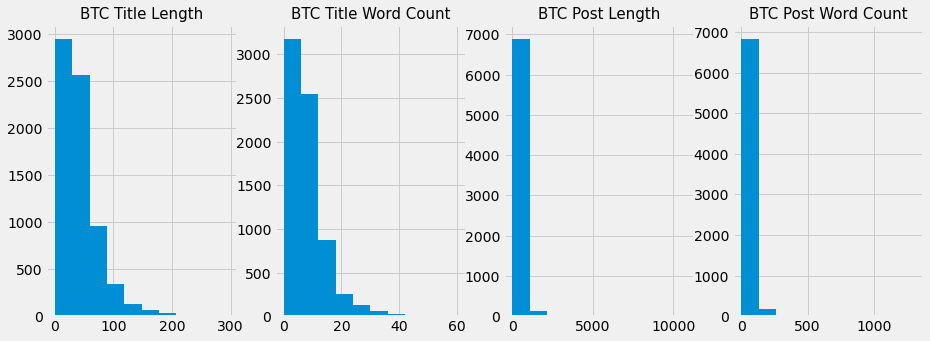

In [35]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 5))
df_bc['title_length'].hist(ax = axes[0])
df_bc['title_word_count'].hist(ax = axes[1])
df_bc['selftext_length'].hist(ax = axes[2])
df_bc['selftext_word_count'].hist(ax = axes[3])

axes[0].set_title('BTC Title Length', fontsize=15)
axes[1].set_title('BTC Title Word Count', fontsize=15)
axes[2].set_title('BTC Post Length', fontsize=15)
axes[3].set_title('BTC Post Word Count', fontsize=15);

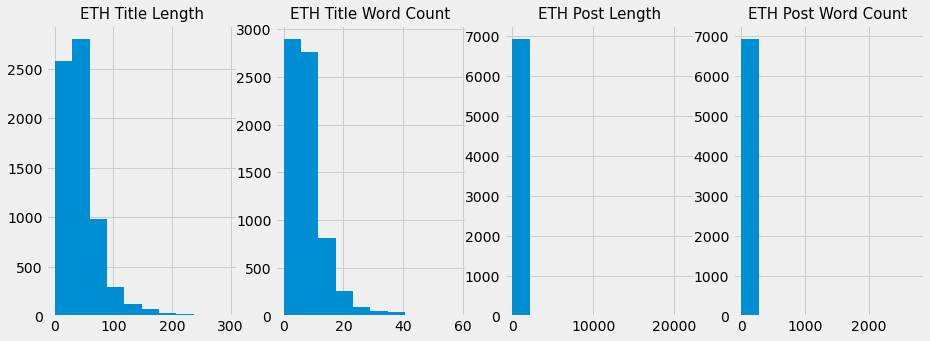

In [36]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 5))
df_eth['title_length'].hist(ax = axes[0])
df_eth['title_word_count'].hist(ax = axes[1])
df_eth['selftext_length'].hist(ax = axes[2])
df_eth['selftext_word_count'].hist(ax = axes[3])

axes[0].set_title('ETH Title Length', fontsize=15)
axes[1].set_title('ETH Title Word Count', fontsize=15)
axes[2].set_title('ETH Post Length', fontsize=15)
axes[3].set_title('ETH Post Word Count', fontsize=15);

A quick look at the title and post character length and word counts don't elucidate much useful information other than they are both positively skewed.

## Most Common Words 

In [37]:
bc_cvec = CountVectorizer(max_features=1_000)
bc_word_counts = bc_cvec.fit_transform(df_bc['title_and_selftext_lem'])
bc_counts = pd.DataFrame(bc_word_counts.todense(), columns=bc_cvec.get_feature_names())

In [38]:
eth_cvec = CountVectorizer(max_features=1_000)
eth_word_counts = eth_cvec.fit_transform(df_eth['title_and_selftext_lem'])
eth_counts = pd.DataFrame(eth_word_counts.todense(), columns=eth_cvec.get_feature_names())

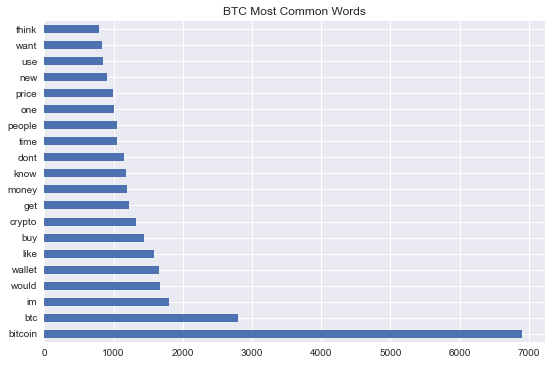

In [39]:
plt.style.use('seaborn')
bc_counts.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('BTC Most Common Words');

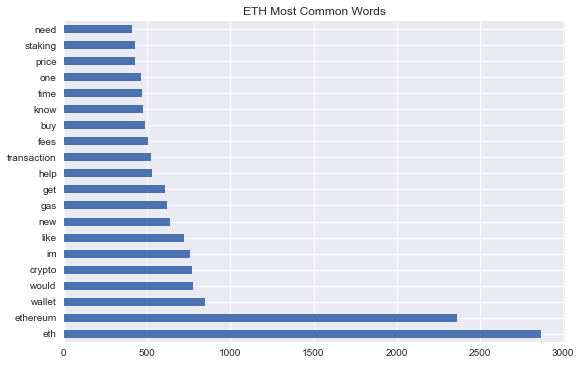

In [40]:
plt.style.use('seaborn')
eth_counts.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('ETH Most Common Words');

There's a fair amount of overlap between the two subreddits' top words. Some notable standouts on the ETH word graph are: transaction, gas, fees, and staking, all of which are unique to that market. Let's add some custom stopwords to remove the obvious words like bitcoin, ethereum, etc and see how that changes the results. 

In [41]:
bc_cvec_stop = CountVectorizer(stop_words=['bitcoin', 'btc'], max_features=1_000, ngram_range=(1,2))
bc_word_counts_stop = bc_cvec_stop.fit_transform(df_bc['title_and_selftext_lem'])
bc_counts_stop = pd.DataFrame(bc_word_counts_stop.todense(), columns=bc_cvec_stop.get_feature_names())

In [42]:
eth_cvec_stop = CountVectorizer(stop_words=\
                            ['ethereum', 'eth', 'gas', 'fees', 'staking', 'removedview', 'contracts'],\
                            max_features=1_000, ngram_range=(1,2))
eth_word_counts_stop = eth_cvec_stop.fit_transform(df_eth['title_and_selftext_lem'])
eth_counts_stop = pd.DataFrame(eth_word_counts_stop.todense(), columns=eth_cvec_stop.get_feature_names())

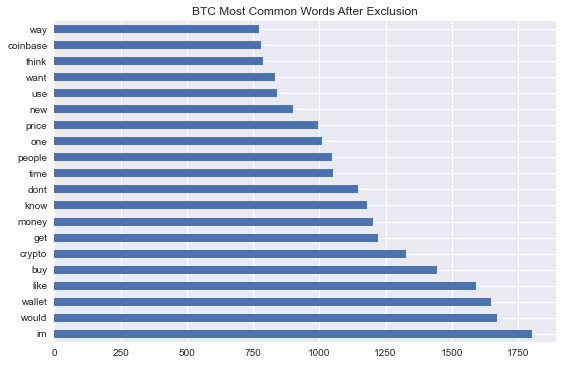

In [43]:
plt.style.use('seaborn')
bc_counts_stop.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('BTC Most Common Words After Exclusion');

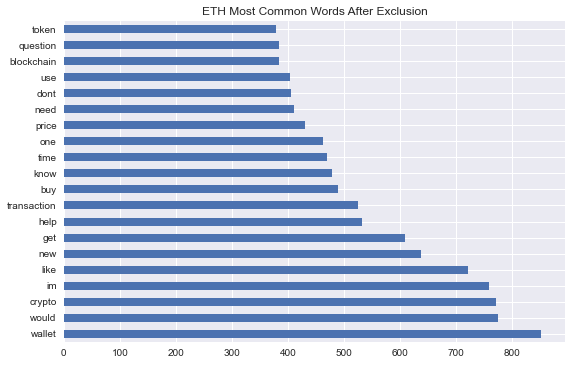

In [44]:
plt.style.use('seaborn')
eth_counts_stop.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('ETH Most Common Words After Exclusion');

Removing obvious words doesn't show much value when looking at single words. Let's try this same process with bigrams and trigrams.

## Most Common Bigrams and Trigrams 

In [45]:
bc_cvec3 = CountVectorizer(max_features=500, ngram_range=(2,3))
bc_ngrams = bc_cvec3.fit_transform(df_bc['title_and_selftext_lem'])
bc_ngrams = pd.DataFrame(bc_ngrams.todense(), columns = bc_cvec3.get_feature_names())

In [46]:
bc_bigrams = [col for col in bc_ngrams.columns if len(col.split()) == 2]
bc_trigrams = [col for col in bc_ngrams.columns if len(col.split()) == 3]

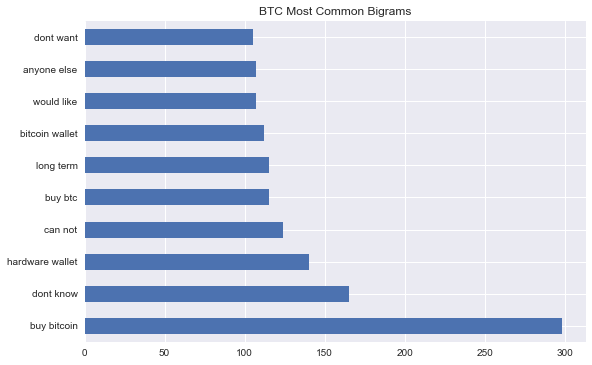

In [47]:
bc_ngrams[bc_bigrams].sum().sort_values(ascending = False).head(10).plot(kind='barh')
plt.title('BTC Most Common Bigrams');

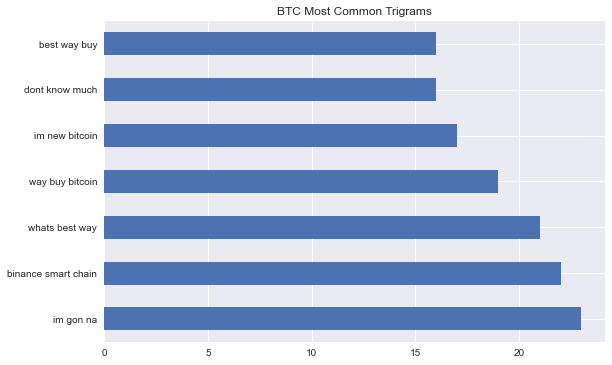

In [48]:
bc_ngrams[bc_trigrams].sum().sort_values(ascending = False).head(10).plot(kind='barh')
plt.title('BTC Most Common Trigrams');

Looking at the bigram and trigram graphs, the most common phrases are ones asking for advice such as, "please let know", "would greatly appreciated", "whats best way."

In [49]:
eth_cvec2 = CountVectorizer(max_features=500, ngram_range=(2,3))
eth_ngrams = eth_cvec2.fit_transform(df_eth['title_and_selftext_lem'])
eth_ngrams = pd.DataFrame(eth_ngrams.todense(), columns = eth_cvec2.get_feature_names())

In [50]:
eth_bigrams = [col for col in eth_ngrams.columns if len(col.split()) == 2]
eth_trigrams = [col for col in eth_ngrams.columns if len(col.split()) == 3]

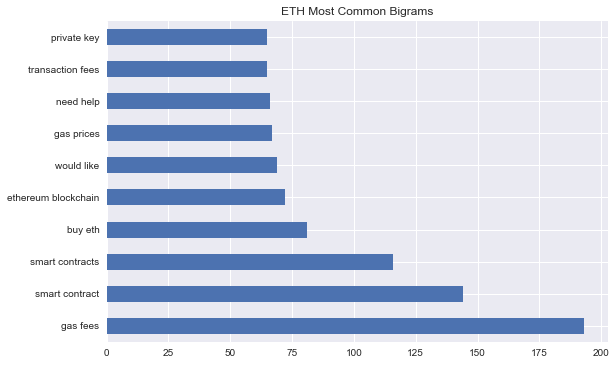

In [51]:
eth_ngrams[eth_bigrams].sum().sort_values(ascending = False).head(10).plot(kind='barh')
plt.title('ETH Most Common Bigrams');

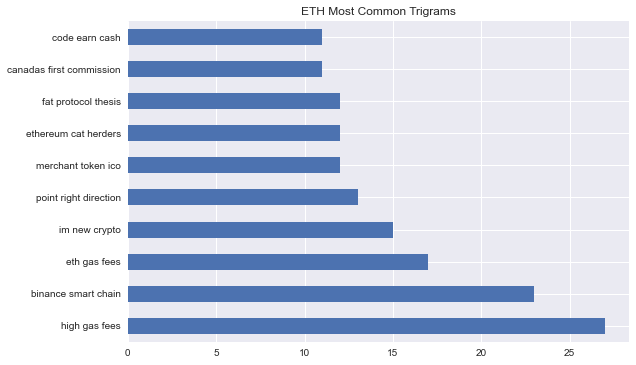

In [52]:
eth_ngrams[eth_trigrams].sum().sort_values(ascending = False).head(10).plot(kind='barh')
plt.title('ETH Most Common Trigrams');

Bitcoin users seem to be either asking for advice or looking to buy bitcoin, while Ethereum users appear to be discussing more nuacned topics like gas fees and the fat protocal thesis.

Now let's remove the the custom stop words from the data and see how that changes the results.

In [53]:
bc_cvec3 = CountVectorizer(stop_words=['bitcoin', 'btc'], max_features=500, ngram_range=(2,3))
bc_ngrams = bc_cvec3.fit_transform(df_bc['title_and_selftext_lem'])
bc_ngrams = pd.DataFrame(bc_ngrams.todense(), columns = bc_cvec3.get_feature_names())

In [54]:
bc_bigrams = [col for col in bc_ngrams.columns if len(col.split()) == 2]
bc_trigrams = [col for col in bc_ngrams.columns if len(col.split()) == 3]

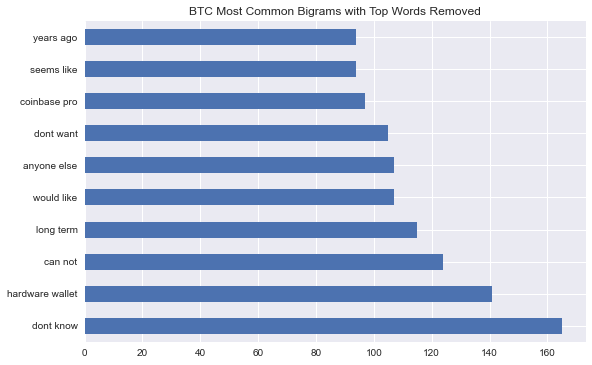

In [55]:
bc_ngrams[bc_bigrams].sum().sort_values(ascending = False).head(10).plot(kind='barh')
plt.title('BTC Most Common Bigrams with Top Words Removed');

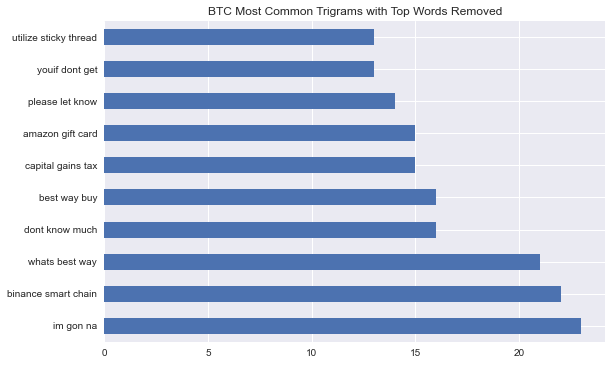

In [56]:
bc_ngrams[bc_trigrams].sum().sort_values(ascending = False).head(10).plot(kind='barh')
plt.title('BTC Most Common Trigrams with Top Words Removed');

In [57]:
eth_cvec2 = CountVectorizer(stop_words=['ethereum', 'eth', 'gas', 'fees', 'staking', 'removedview', 'contracts'],\
                            max_features=500, ngram_range=(2,3))
eth_ngrams = eth_cvec2.fit_transform(df_eth['title_and_selftext_lem'])
eth_ngrams = pd.DataFrame(eth_ngrams.todense(), columns = eth_cvec2.get_feature_names())

In [58]:
eth_bigrams = [col for col in eth_ngrams.columns if len(col.split()) == 2]
eth_trigrams = [col for col in eth_ngrams.columns if len(col.split()) == 3]

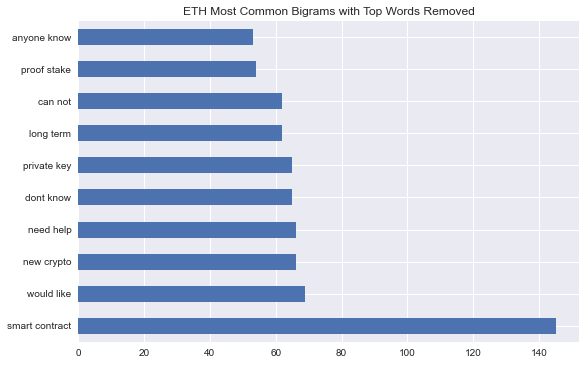

In [59]:
eth_ngrams[eth_bigrams].sum().sort_values(ascending = False).head(10).plot(kind='barh')
plt.title('ETH Most Common Bigrams with Top Words Removed');

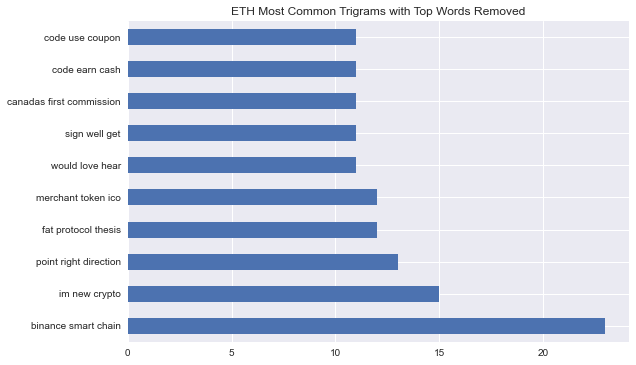

In [60]:
eth_ngrams[eth_trigrams].sum().sort_values(ascending = False).head(10).plot(kind='barh')
plt.title('ETH Most Common Trigrams with Top Words Removed');

After removing the main distinguishing words, the main connection between the two subreddits is users looking for advice/assistance with phrases like, "best way", "im new", "anyone know", "please help". In terms of diiferences, Smart contracts only apply to ETH so it makes sense that it wouldn't be in BTC (could argue it should've be placed in the custom stopwords).  

Written on Friday: I wish I would've spent more time on building a comprehensive custom stop word list to start pulling back even more layers of common words from each subreddit. This way I may have done a more successful job of extracting differences between these communities beyond the jargon each group would obviously use.

### Wordcloud 

In [61]:
bc_text = ' '.join(text for text in df_bc['title_and_selftext'])

In [62]:
eth_text = ' '.join(text for text in df_eth['title_and_selftext'])

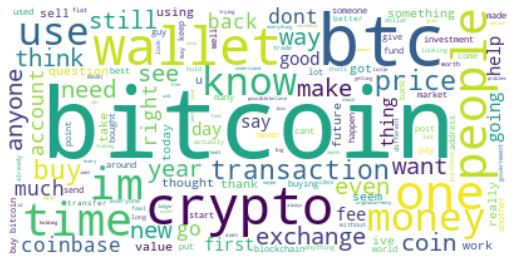

In [63]:
wordcloud = WordCloud(max_words=150, background_color='white').generate(bc_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

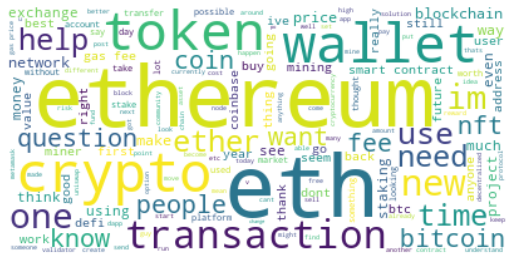

In [64]:
wordcloud = WordCloud(max_words=150, background_color='white').generate(eth_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

Another way to visualize the previous graphs are in Word Clouds. Although it's been said that word clouds do not equal data science, I thought it be fun to include them anyway.

### Save updated Dataframe for Modelling

In [65]:
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,title_and_selftext,is_bitcoin,selftext_tokens,title_and_selftext_tokens,selftext_lem,title_and_selftext_lem,title_word_count,title_length,selftext_word_count,selftext_length
0,passive bitaltcoin apps,hi kinda new crypto saw thread day good recomm...,Bitcoin,1619299928,Comfortable-Hall-501,7,1,True,2021-04-24,passive bitaltcoin apps hi kinda new crypto sa...,1,"[hi, kinda, new, crypto, saw, thread, day, goo...","[passive, bitaltcoin, apps, hi, kinda, new, cr...",hi kinda new crypto saw thread day good recomm...,passive bitaltcoin apps hi kinda new crypto sa...,3,23,30,208
1,why i think dorian satoshi nakamoto is creator...,know dorian denied creator bitcoin lived town ...,Bitcoin,1619300188,bruh_360,4,1,True,2021-04-24,think dorian satoshi nakamoto creator bitcoin ...,1,"[know, dorian, denied, creator, bitcoin, lived...","[think, dorian, satoshi, nakamoto, creator, bi...",know dorian denied creator bitcoin lived town ...,think dorian satoshi nakamoto creator bitcoin ...,10,57,61,448
2,why wont bitcoin get regulated,im new cryptocurrency even blockchain technolo...,Bitcoin,1619300698,No-Librarian9752,9,1,True,2021-04-24,wont bitcoin get regulated im new cryptocurren...,1,"[im, new, cryptocurrency, even, blockchain, te...","[wont, bitcoin, get, regulated, im, new, crypt...",im new cryptocurrency even blockchain technolo...,wont bitcoin get regulated im new cryptocurren...,5,30,52,364
3,the beginning of a journey,hey everyone last week emotional rollercoaster...,Bitcoin,1619301239,Mammoth_Lettuce_6706,11,1,True,2021-04-24,beginning journey hey everyone last week emoti...,1,"[hey, everyone, last, week, emotional, rollerc...","[beginning, journey, hey, everyone, last, week...",hey everyone last week emotional rollercoaster...,beginning journey hey everyone last week emoti...,5,26,185,1232
4,real inflation rates,pretty famous study inflection point diminishi...,Bitcoin,1619302086,Easteuroblondie,93,1,True,2021-04-24,real inflation rates pretty famous study infle...,1,"[pretty, famous, study, inflection, point, dim...","[real, inflation, rates, pretty, famous, study...",pretty famous study inflection point diminishi...,real inflation rates pretty famous study infle...,3,20,94,679


In [66]:
df.to_csv('./data/clean_full.csv', index=False)